In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import pickle
import requests
import bs4 as bs

import datetime as dt
import os

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

style.use('ggplot')


%matplotlib inline
# %matplotlib qt # uncomment this to get a window where you can zoom / move / save 

In [3]:
from tqdm import tqdm

import yfinance as yfin
yfin.pdr_override()

In [4]:
def save_sp500_tickers():
    resp = requests.get(
        'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'id': 'constituents'})

    tickers = []
    for row in table.findAll('tr')[1:]:
        tickers.append(row.findAll('td')[0].text.replace('\n', ''))

    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)

    return np.array(tickers)

In [5]:
def get_data_from_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = dt.datetime(2000, 1, 1)
    end = dt.datetime(2016, 12, 31)

    for ticker in tqdm(tickers):
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.get_data_yahoo(ticker, start, end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))

In [6]:
# get_data_from_yahoo()

In [7]:
def compile_data():
    with open("sp500tickers.pickle", 'rb') as f:
        tickers = pickle.load(f)

    main_df = pd.DataFrame()

    for ticker in tqdm(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)

        df.rename(columns={'Adj Close': ticker}, inplace=True)

        df.drop(['Open', 'High', 'Low', 'Close', 'Volume'],
                axis=1, inplace=True)

        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')
    main_df.to_csv('sp500_joined_adjcloses.csv')

In [8]:
# compile_data()

In [9]:
def visualize_data():
    df = pd.read_csv('sp500_joined_adjcloses.csv')
#     df['AAPL'].plot()
#     plt.show()
    df_corr = df.corr()
    sns.heatmap(df_corr, xticklabels=1, yticklabels=1, cmap="RdYlGn")

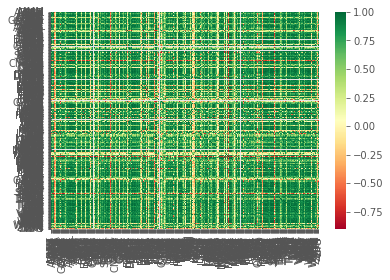

In [10]:
visualize_data()